<a href="https://colab.research.google.com/github/r-meleshko/kaggle/blob/main/dog_breed_identification_NASNetLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Data preprocessing

In [ ]:
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import NASNetLarge

In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c dog-breed-identification
!unzip dog-breed-identification.zip
!mkdir models

In [ ]:
wd = Path(".")
# Load labels
labels = pd.read_csv(wd / "labels.csv")
labels.id = labels.id.apply(lambda x: f"{x}.jpg")
labels.head(2)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo


(418, 500, 3)


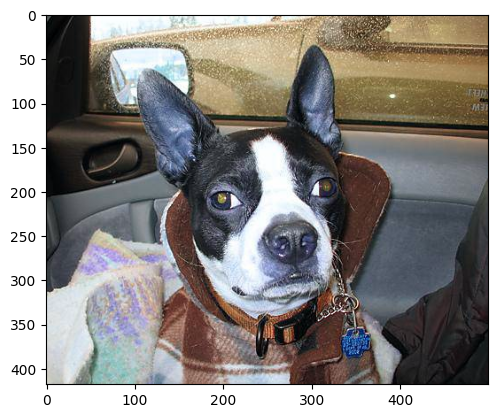

In [ ]:
import cv2

# Checkout one image
image = cv2.imread(str(wd / "test/0b549d7b0a972428bfca5bec213ce494.jpg"), cv2.IMREAD_COLOR)
print(image.shape)
plt.imshow(image)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(labels, stratify=labels['breed'], test_size=0.2, random_state=420)


img_size = (331, 331)
batch_size = 32

# Create a data generator with data augmentaiton
train_datagen = ImageDataGenerator(
    rescale=1./255,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
    horizontal_flip=True,
#    fill_mode="nearest",
)


# Prepare the generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(wd / 'train'),
    x_col="id",
    y_col="breed",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=str(wd / 'train'),
    x_col="id",
    y_col="breed",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size
)



# Create test generator
test_filenames = os.listdir(wd / 'test')
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # the dataframe for the test set will be created later
    directory=str(wd / 'test'),
    x_col="id",
    class_mode=None,  # no labels
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False  # keep data in the same order as filenames
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


Text(0.5, 1.0, 'kerry_blue_terrier')

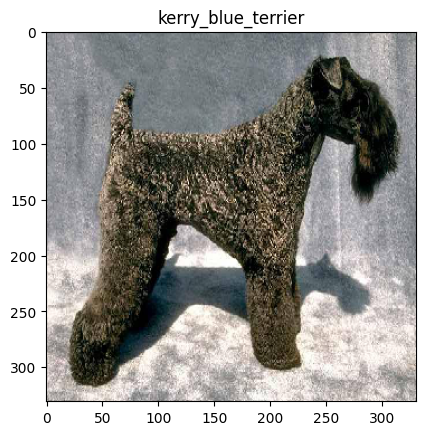

In [ ]:
labels_map = dict((v,k) for k,v in train_generator.class_indices.items())
x, y = next(train_generator)
plt.imshow(x[0])
plt.title(labels_map[y[0].argmax()])

# 2 - Model

## 2.1 - NASNetLarge (Neural Architecture Search Network)

In [ ]:
shape = (331, 331, 3)

nasnet = NASNetLarge(weights="imagenet", include_top=False, input_shape=shape)
nasnet.trainable = False

model = keras.Sequential([
    nasnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, "relu"),
    layers.Dropout(0.5),
    layers.Dense(120, "softmax")
])
model.summary()

343610240/343610240 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               2064896   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               61560     
                                                                 
Total params: 87,043,274
Trainable params: 2,126,456
No

In [ ]:
opt = keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
filepath = wd / "models/nasnetlarge_model.h5"

# Define callbacks
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

earlystop = keras.callbacks.EarlyStopping(patience=4, min_delta=0.001, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(str(filepath), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
time_callback = TimeHistory()
callbacks_list = [earlystop, checkpoint, time_callback]

train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      validation_data=train_generator,
      validation_steps=validation_steps,
      epochs=25,
      callbacks=callbacks_list
)

In [ ]:
np.mean(time_callback.times)

290.1883923113346

In [ ]:
model.evaluate(validation_generator)

64/64 [==============================] - 57s 880ms/step - loss: 0.3740 - accuracy: 0.9149


[0.3739994764328003, 0.9149144291877747]

In [ ]:
import matplotlib.pyplot as plt

# Get the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(loss) + 1)

# Visualize loss history
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Prediction and Submission

In [ ]:
pred = model.predict(test_generator)
pred.shape

324/324 [==============================] - 277s 840ms/step


(10357, 120)

In [ ]:
submission = pd.read_csv(wd / "sample_submission.csv")
submission = pd.DataFrame(pred, columns=submission.columns[1:])
submission.insert(0, "id", test_df.id)
submission.id = submission.id.str.rstrip('.jpg')
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c dog-breed-identification -f submission.csv -m "First submission using transfer learning with NASNetLarge."

100% 16.4M/16.4M [00:01<00:00, 9.20MB/s]
Successfully submitted to Dog Breed Identification

In [ ]:
!kaggle competitions submissions -c dog-breed-identification

fileName        date                 description                                                 status    publicScore  privateScore  
--------------  -------------------  ----------------------------------------------------------  --------  -----------  ------------  
submission.csv  2023-07-25 17:29:48  First submission using transfer learning with NASNetLarge.  complete  0.32376      0.32376       


In [ ]:
file_path = 'models/nasnetlarge_model.h5'
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>